# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения 
    * SGD+momentum, Adam
    
Адрес для посылки ДЗ mfti_2018_hw03@mail.ru

# Требуемые модули:
1. pytorch // [инструкция по установке](https://pytorch.org/)
2. torchvision // pip install ...
3. matplotlib  //
4. PIL
5. scipy
6. numpy
7. pickle

# Требования
1. Присылаем этот ноутбук только с полностью выполненными заданиями.
2. Файл должен называть MFTI_2019_hw03_ФАМИЛИЯ_ИМЯ.ipynb
3. Заданние должно быть выполнено до 24.03.2019 до 23:59.
4. После проверки у Вас будет одна попытка для исправления замечаний. 

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку <font collor='red'>__pytorch__</font>. Получаем на вход тензор размером $(C_{in}, H, W)$, на выходе получаем тензор $(C_{out}, H_{out}, W_{out})$.
$$
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки с параметрами:

$\large k $ - ядро свертки, тензор с парамерами $C_{in}, H_k, W_k,$ <br>
$stride_{H,W}$ - шаг ядра свертки, <br>
$padding_{H,W} $ - размер паддинга.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [36]:
# функции тестирования
from tests_functions import * 

In [43]:
import torch
import torchvision as tv
from torch.nn.modules import ZeroPad2d

In [59]:
def make_padding(x, padding):
    """
    Args:
        x: исходная матрица
        padding: tuple-элемент с размерами паддинга по соответсвующей оси
    Return:
        исходная матрица с добавлением паддингов
    """
    if padding == (0,0):
        return x
    
    x_with_padding = add_padding_along_ax(x, padding[0], 2)
    return add_padding_along_ax(x_with_padding, padding[1], 3)
    

def add_padding_along_ax(x, padding, ax):
    """
    Args:
        x: исходная матрица
        padding: размер паддинга
        ax: ось, вдоль которой добавится паддинг
    Return:
        матрица x с добавленным паддингом по оси ax
    """
    
    padding_matrix = torch.zeros([elem if i != ax else padding\
                                  for (i,elem) in enumerate(x.shape)])
    return torch.cat((padding_matrix, x, padding_matrix), ax)

def get_sub_window(x, indices, sizes):
    """
    Args:
        x: исходная матрица
        indices: верхняя левая точка окна, которое будем вычислять
        sizes: размер окна (= kernel size)
    Return:
        подматрица x размера x.shape[0]*sizes[0]*sizes[1]
    """
    return x[:, indices[0]:(indices[0] + sizes[0]),\
             indices[1]:(indices[1] + sizes[1])] 

# прототип функции 
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда, задаются в формате HxW
    :param  padding:  tuple - параметры паддинга, задаются в формате HxW
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
    
    if len(x.shape) == 3:
        x = torch.unsqueeze(x, 0)
    
    B, C, H_in, W_in = x.shape
    H_out = (H_in + 2 * padding[0] - kernel[0].shape[0]) // stride[0]  + 1
    W_out = (W_in + 2 * padding[1] - kernel[0].shape[1]) // stride[1]  + 1
    
    x_with_padding = make_padding(x, padding)
    x_out = torch.empty((B, H_out, W_out))
    
    for i in range(0, H_out):
        for j in range(0, W_out):
            for b in range(B):
                window = get_sub_window(x_with_padding[b],
                                       (i*(stride[0]), j*stride[1]),
                                       (kernel[0].shape[0], kernel[0].shape[1]))
                x_out[b][i][j] = (window * kernel).sum()
    
    if B == 1:
        x_out = torch.squeeze(x_out, 0)
    
    if bias is not None:
        x_out = x_out + bias
    
    return x_out


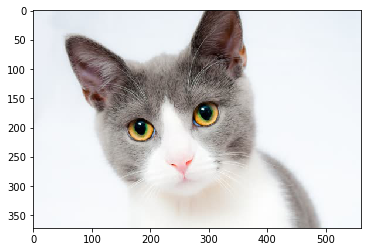

In [60]:
# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [61]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [62]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Загружаем картинку 

### Делаем свертку картинки ядром

torch.Size([370, 558])


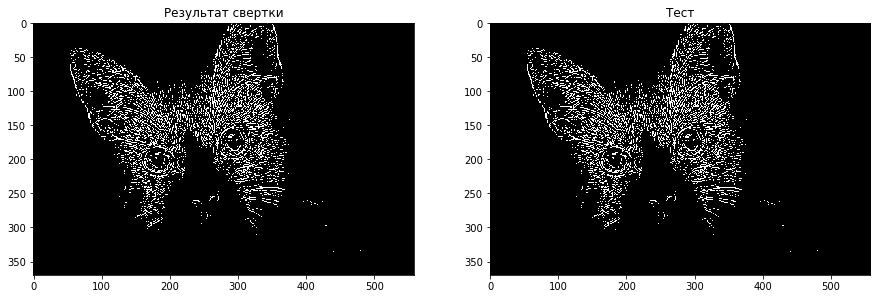

In [63]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_01.pth')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [64]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


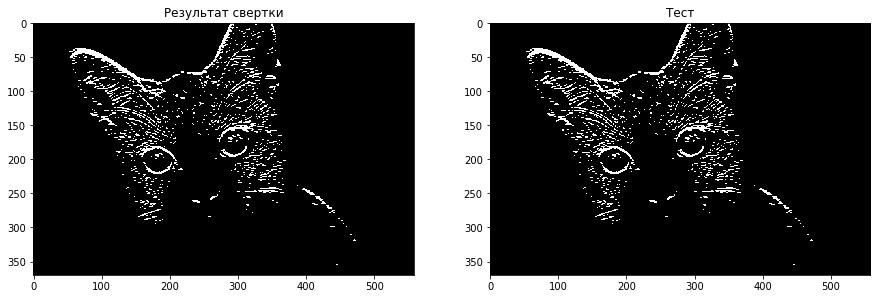

In [65]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image = torch.squeeze(o_image, 0)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_02.pth')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [66]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


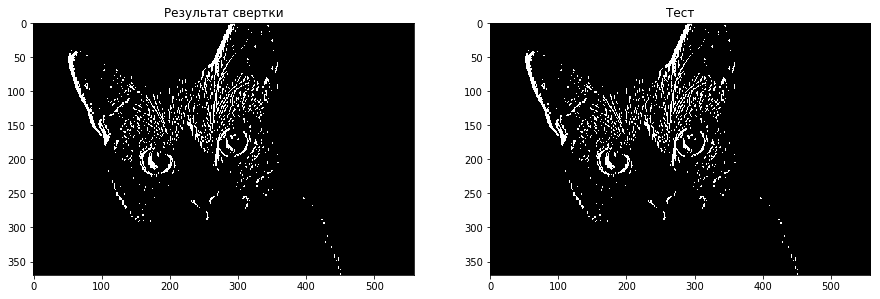

In [68]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_03.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([186, 280])
torch.Size([186, 280])


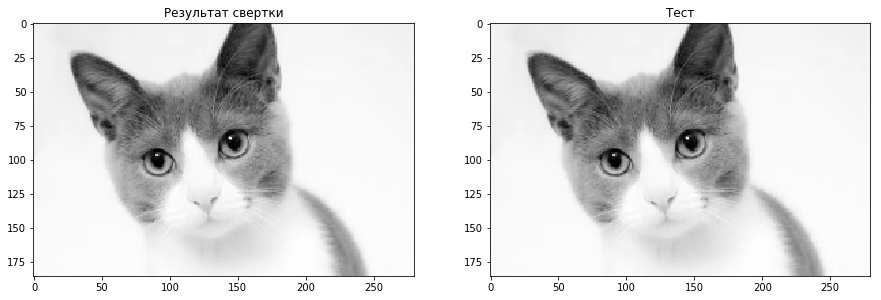

In [69]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
# torch.save(o_image, './data/kernel_05.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_05.pth')
assert o_image.size() == torch.Size([186, 280]), 'Размер выходного изображения не совпадает с размером теста'
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 1, padding 1

torch.Size([372, 560])


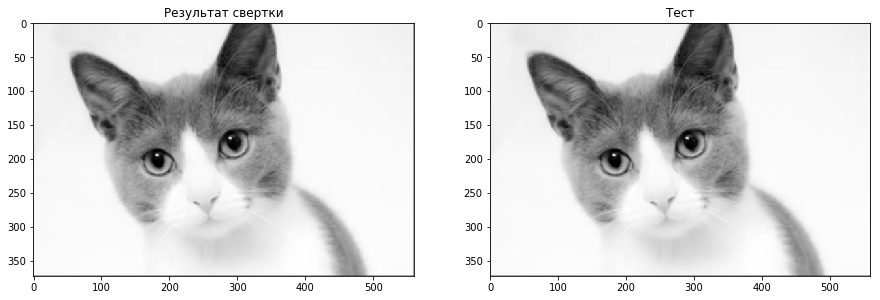

In [70]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(1,1), padding=(1,1))
o_image /= 4 # усредняем
#torch.save(o_image, './data/kernel_04.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_04.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 2, padding 2

torch.Size([187, 281])


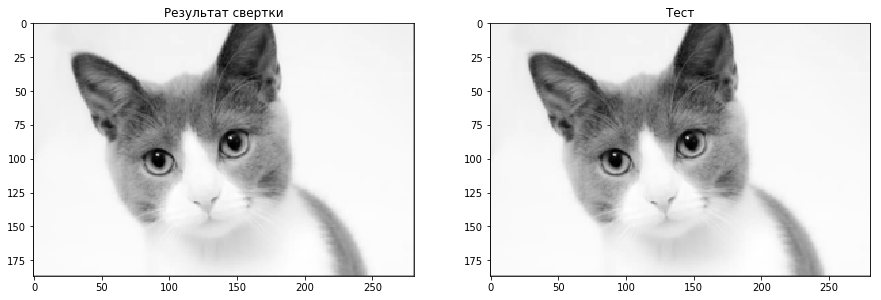

In [71]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2), padding=(2,2))
o_image /= 4 # усредняем
test_conv(o_image, './data/kernel_06.pth')

### Ядро свертки с гаусовым распределением

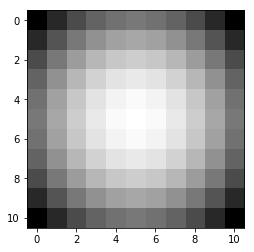

In [72]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

torch.Size([362, 550])


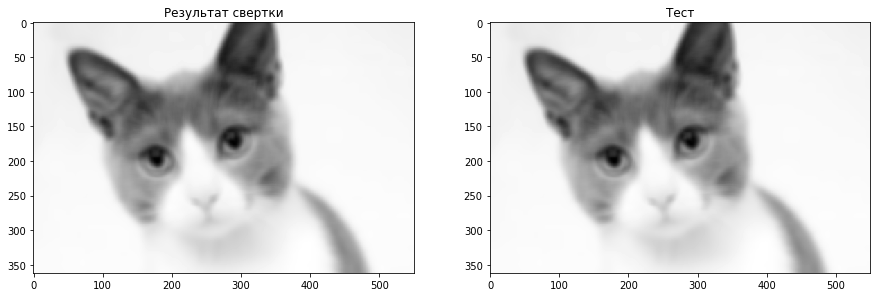

In [73]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
test_conv(o_image, './data/kernel_07.pth', False)

# Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - \mu}{ \sqrt{\sigma^2 + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя \ в \ режиме\ тренировки
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \\ параметры считаются в процессе тренировки
\gamma, b $ - обучаемые параметры параметры.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй (компонентом векторв)

Нужные функции
```python
import torch
torch.zeros - создать тензор заполненный нулями
torch.ones - создать тензор заполненный единицами
torch.Tensor - создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  - среднее и дисперсия
x.uniform_ - заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) - разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1
x.unsqueeze(dim) - добавить размерность в тензор
x.squeeze - убрать размерность

```

In [18]:
import torch.nn as nn
import numpy as np

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        """
         Инициализация BN
         Если задан флаг afine, то должны быть проинициализированны матрицы гамма и b
         для осуществления афинных преобразований в процессе тренировки и теста.
         Обучаемый параметры устанавливаем как тензора соответсвующей размерности и сохраняем 
         их 
         self.weight
         self.bias
         В данном ДЗ мы не обучаем эти параметры, лишь реализуем саму концепцию.
         
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование в процессе обучения.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        super().__init__()
        self.in_channels = in_channels
        self.afine = afine
        self.beta = beta
        self.epsilon = epsilon
        if self.afine:
            self.weight = torch.Tensor(1, self.in_channels, 1, 1).uniform_()
            self.bias = 0
        self.running_mean = 0.
        self.running_var = 0.
    
    
    def exp_running_avg_(self, running, new):
        """
        Вычисление экспоненциального скользящего среднего
        Args:
            running: старое значение
            new: новое значение
        """
        return self.beta * running + (1. - self.beta) * new    
        
        
    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        используем для расчета праметры gamma и b КАК обучаемые, т.е. учитываем, 
        что эти параметры должны быть обучены в процессе тренировки. 
        """
        
        was_unsqueezed = False
        if len(x.shape) == 3:
            x.unsqueeze(0)
            was_unsqueezed = True
        
        B, C, H, W = x.shape
        assert C == self.in_channels

        x = x.transpose(0,1)
        x_flat = torch.Tensor(torch.reshape(x, (C, B*H*W)))

        if self.training:
            self.mean = torch.mean(x_flat, 1).unsqueeze(0).transpose(0,1)
            self.var = torch.var(x_flat, 1).unsqueeze(0).transpose(0,1)
            
            x_norm = (x_flat - self.mean) / torch.sqrt(self.var + self.epsilon)
            x_norm = torch.Tensor(torch.reshape(x_norm, (C, B, H, W)))
            x_norm = x_norm.transpose(0,1)
        
            out = x_norm
            if self.afine:
                out =  self.weight * x_norm + self.bias
                        
            self.running_mean = self.exp_running_avg_(self.running_mean, self.mean)
            self.running_var = self.exp_running_avg_(self.running_var, self.var)
            
        else:
            x_norm = (x_flat - self.running_mean) / torch.sqrt(self.running_var + self.epsilon)
            x_norm = torch.Tensor(torch.reshape(x_norm, (C, B, H, W)))
            x_norm = x_norm.transpose(0,1)
            out = x_norm
            if self.afine:
                out = self.weight * x_norm + self.bias
        
        if was_unsqueezed:
            out.squeeze()
        
        return out
            


### Проверяем работу батч нормадлизации на котэ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([372, 560, 3])


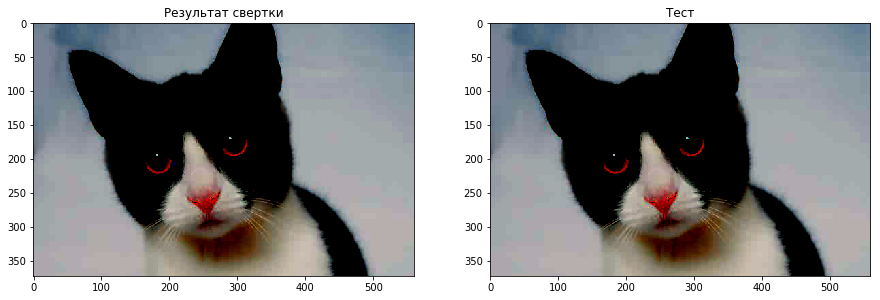

In [20]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
# o_image
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot

o_image = o_image.transpose(0,2).transpose(0,1)

test_conv(o_image, './data/bn_01.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([372, 560, 3])


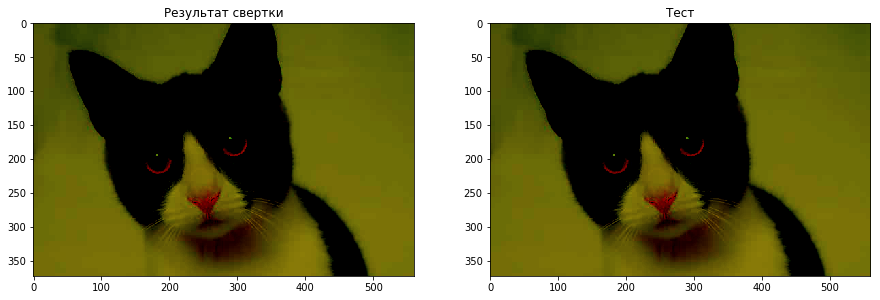

In [21]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
# Поэтому, чтобы получить детерменированный результат устанавливаем seed
torch.manual_seed(999)

bn = BatchNorm2d(3, afine=True)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
test_conv(o_image, './data/bn_02.pth')
#print (o_image.size())

In [22]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

### Проверим как реализация работает на большом сете картинок
Цель проверить расчет running_mean and running_var, эти переменные мы расчитываем в режиме тренировки

In [23]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

/home/alexander/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/alexander/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


(70000, 1, 28, 28)


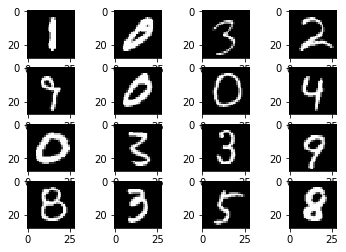

In [24]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются скользящее среднее значение в процессе тренировки

In [25]:
from tqdm import tqdm_notebook
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    np.random.seed(999)
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in tqdm_notebook(range(nbatches)):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn.forward(x)
#             print(bn.running_mean)
#             print(bn.running_var)
            mean_curve += [ bn.running_mean ] 
            var_curve +=  [ bn.running_var ]
    return mean_curve, var_curve

In [26]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)

# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

BN beta=09


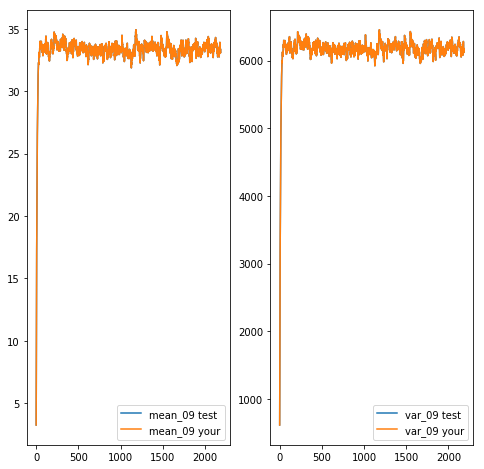

In [27]:
print ("BN beta=09")
test_bn_plots(mean_curve_09, var_curve_09, '09')

BN beta=099


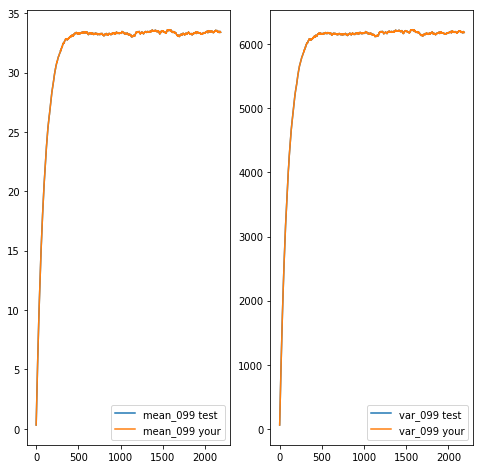

In [28]:
print ("BN beta=099")
test_bn_plots(mean_curve_099, var_curve_099, '099')

BN beta=05


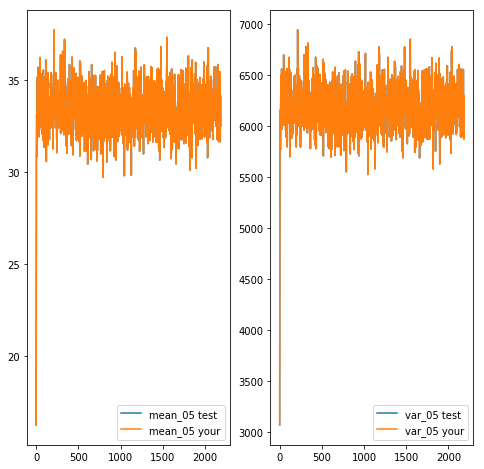

In [29]:
print ("BN beta=05")
test_bn_plots(mean_curve_05, var_curve_05, '05')

Смотрим какие значения средних и дисперсий у нас получились

In [31]:
print ("Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed")
assert int(bn_09.running_mean[0]) == 33
assert int(bn_099.running_mean[0]) == 33
assert int(bn_05.running_mean[0]) == 32
assert int(bn_09.running_var[0]) == 6136
assert int(bn_099.running_var[0]) == 6180
assert int(bn_05.running_var[0]) == 6038
print ('ok')

Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed
ok


Посмотрим как повлияла батч нормализация на изображения

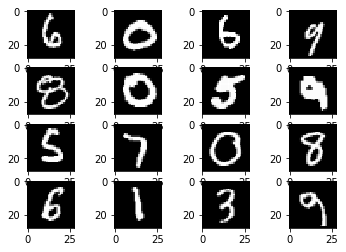

In [34]:
n=4
bn = bn_09
bn.train(False) # эмулируем режим тренировки
np.random.seed(666)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze()
    # загрузим сохраненный тестовый тензор 
    t_I = torch.load('./data/bn_minst_%2d.pth'%i)
    # проверим, что нормализованный и тестовый тензор совпадают 
    assert (I == t_I).all(), "Что-то не так нормализованный тензор через running_mean и running_var не совпадают"
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), построить графики для различных параметров для каждого алгоритма, сделать выводы о скорости сходимости


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \ m_{t-1} + (1 - \alpha)\ g - момент \\ 
v_t &= \beta \ v_{t-1} +  (1-\beta)\ g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^{\frac{1}{2}}}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$


In [0]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры 
        # обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] 
            eps = group['eps']
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                # забираем тензор градиента    
                grad = p.grad.data
                
                # тут хранятся значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # скользящее среднее по квадрату градиентов
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                        
                # запоминаем шаг
                state['step'] += 1

                # Считаем параметры. Записывать обратно в state не нужно,
                # ибо мы получаем ссылку
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                
                denom = exp_avg_sq.sqrt().add_(eps)
                
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                

                # обновляем веса в p.data, 
                p.data.addcdiv_(-step_size, exp_avg, denom)
                
        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta m_{t-1} - (1- \beta) g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha m_{t-1} - \lambda g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [0]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None
        for group in self.param_groups:
            beta = group['beta']

            for p in group['params']:
                
                if p.grad is None:
                    continue
                    
                d_p = p.grad.data
                
                if beta != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                        buf.mul_(beta).add_(1. - beta, d_p)
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(beta).add_(1. - beta, d_p)
                    
                    d_p = buf

                p.data.add_(-group['lr'], d_p)

        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [0]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [0]:
USE_CUDA=True

In [0]:
torch.cuda.is_available()

True

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        # добавляем бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))            
        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        # добавляем бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            
        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))
        # Линейный слой классификатора
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        return x

## Функция обучения модели

In [0]:
import numpy as np
from tqdm import tqdm_notebook

def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in tqdm_notebook(range(nbatches)):#nbatches
            optimizer.zero_grad()
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss )
            loss.backward()
            optimizer.step()  
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [0]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0)
loss_curve_sgd = fit_net(20, net, optimizer)


Do epoch 0 with loss 0.11724609410484796



Do epoch 1 with loss 0.050761715102315655



Do epoch 2 with loss 0.040424059042523976



Do epoch 3 with loss 0.03347378247641078



Do epoch 4 with loss 0.030024100921172556



Do epoch 5 with loss 0.02621511563788171



Do epoch 6 with loss 0.024038657423400094



Do epoch 7 with loss 0.02248768209661585



Do epoch 8 with loss 0.02005737550832607



Do epoch 9 with loss 0.018991726705703114



Do epoch 10 with loss 0.01668529531688084



Do epoch 11 with loss 0.015260657764865647



Do epoch 12 with loss 0.014761760820658935



Do epoch 13 with loss 0.013681704853842342



Do epoch 14 with loss 0.013028387768959749



Do epoch 15 with loss 0.012110240689330195



Do epoch 16 with loss 0.010811077169375601



Do epoch 17 with loss 0.01066762499875765



Do epoch 18 with loss 0.009201316625411292



Do epoch 19 with loss 0.00971571268845106


## SGD с моментом

In [0]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(20, net, optimizer)


Do epoch 0 with loss 0.13777973129493654



Do epoch 1 with loss 0.059174199343736064



Do epoch 2 with loss 0.046872587384810226



Do epoch 3 with loss 0.038176316657211336



Do epoch 4 with loss 0.03371625409300163



Do epoch 5 with loss 0.03002675763741442



Do epoch 6 with loss 0.027537344601882556



Do epoch 7 with loss 0.025692654799995326



Do epoch 8 with loss 0.022037221938984875



Do epoch 9 with loss 0.020215551082298642



Do epoch 10 with loss 0.019141114917747715



Do epoch 11 with loss 0.0172950546144349



Do epoch 12 with loss 0.017005300710585



Do epoch 13 with loss 0.015203338911885479



Do epoch 14 with loss 0.013705412073254203



Do epoch 15 with loss 0.012371019257984589



Do epoch 16 with loss 0.011328504579657008



Do epoch 17 with loss 0.010905099599177182



Do epoch 18 with loss 0.010186870136542249



Do epoch 19 with loss 0.00945739704258757


## Adam

In [0]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(20, net, optimizer)


Do epoch 0 with loss 0.1855935225200213



Do epoch 1 with loss 0.05589091510988455



Do epoch 2 with loss 0.042230090301098054



Do epoch 3 with loss 0.036136740845128565



Do epoch 4 with loss 0.031453358138062715



Do epoch 5 with loss 0.02725905170944184



Do epoch 6 with loss 0.025374270362107088



Do epoch 7 with loss 0.02265656878474408



Do epoch 8 with loss 0.0203021905924929



Do epoch 9 with loss 0.018495606020783685



Do epoch 10 with loss 0.016641062211802515



Do epoch 11 with loss 0.01613670443188932



Do epoch 12 with loss 0.014376371999354893



Do epoch 13 with loss 0.014032661780364945



Do epoch 14 with loss 0.012399143962845144



Do epoch 15 with loss 0.01169687400614959



Do epoch 16 with loss 0.010914592764738081



Do epoch 17 with loss 0.010121218135734151



Do epoch 18 with loss 0.010722764526092702



Do epoch 19 with loss 0.008615324796696126


# Кривые обучения

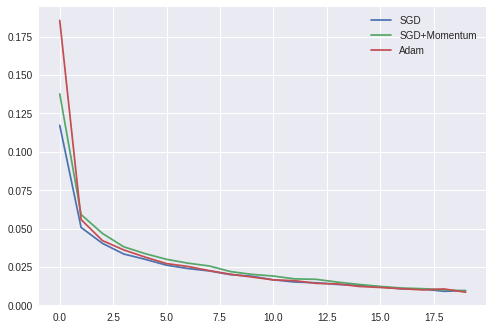

In [0]:
from matplotlib import pyplot as plt
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

### Выводы
Тут нужно написать выводы по сравнению скорости сходимлости алгоритмов SGD, SGD + Momentum, ADAM для различных праметров
1. lr - коэффициент обучения для всех элгоритмов (0.1, 0.01, 0.001, 0.0001) при фиксированных остальных гиперпараметрах 
2. beta - для SGD + momentum (0,9, 0,99, 0,5) для лучшего графика в пункте 1.
3. beta1, beta2 - для ADAM - для различных значений (0,9, 0,99, 0,5) для лучшего графика в пункте 1.

TODO

In [1]:
lr = [0.1, 0.01, 0.001, 0.0001]
beta = [0.9, 0.99, 0.5]
betas = [
          (0.9, 0.99), (0.9, 0.9), (0.9, 0.5), 
          (0.5, 0.5), (0.5, 0.9), (0.5, 0.99),
          (0.99, 0.5), (0.99, 0.9), (0.99, 0.99)
        ]

In [0]:
#SGD + Momentum
# запускалось на google colab
loss_curve_sgd_momentum = []

for lr_ in lr:
    for beta_ in beta:
        net = Net(batchnorm=True)
        net = net.cuda() if USE_CUDA else net
        optimizer = SGD(net.parameters(), lr=lr_, beta=beta_)
        loss_curve_sgd_momentum_ = fit_net(20, net, optimizer)
        loss_curve_sgd_momentum.append((loss_curve_sgd_momentum_, lr_, beta_))


Do epoch 0 with loss 0.1240645998541247



Do epoch 1 with loss 0.05482384241235055



Do epoch 2 with loss 0.043462671571171445



Do epoch 3 with loss 0.03735693611943891



Do epoch 4 with loss 0.0327879783220906



Do epoch 5 with loss 0.03064077866706992


In [0]:
#ADAM
# запускалось на google colab

loss_curve_adam = []

for lr_ in lr:
    for betas_ in betas:
        net = Net(batchnorm=True)
        net = net.cuda() if USE_CUDA else net
        optimizer = Adam(net.parameters(), lr=lr_, betas=betas_)
        loss_curve_adam_ = fit_net(20, net, optimizer)
        loss_curve_adam.append((loss_curve_adam_, lr_, betas_))

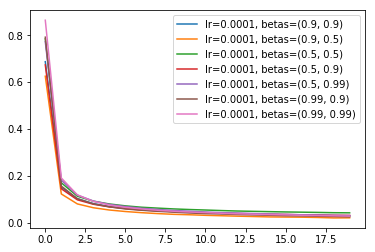

In [36]:
for (curve_adam, lr, betas) in loss_curve_adam:
    if lr == 0.0001 and betas!=(0.9, 0.99) and betas!=(0.99, 0.5):
        plt.plot(curve_adam, label="lr={}, betas={}".format(lr, betas))
  
    
plt.legend()
plt.show()

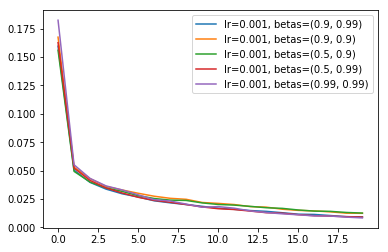

In [37]:
for (curve_adam, lr, betas) in loss_curve_adam:
    if lr == 0.001 and betas != (0.5, 0.5) and betas != (0.9,0.5) and betas != (0.99, 0.5) and betas != (0.99, 0.9):
        plt.plot(curve_adam, label="lr={}, betas={}".format(lr, betas))

plt.legend()
plt.show()

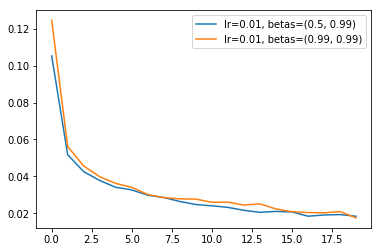

In [38]:
for (curve_adam, lr, betas) in loss_curve_adam:
    if lr == 0.01 and (betas == (0.99, 0.99) or betas == (0.5, 0.99)):
        plt.plot(curve_adam, label="lr={}, betas={}".format(lr, betas))
        
plt.legend()
plt.show()

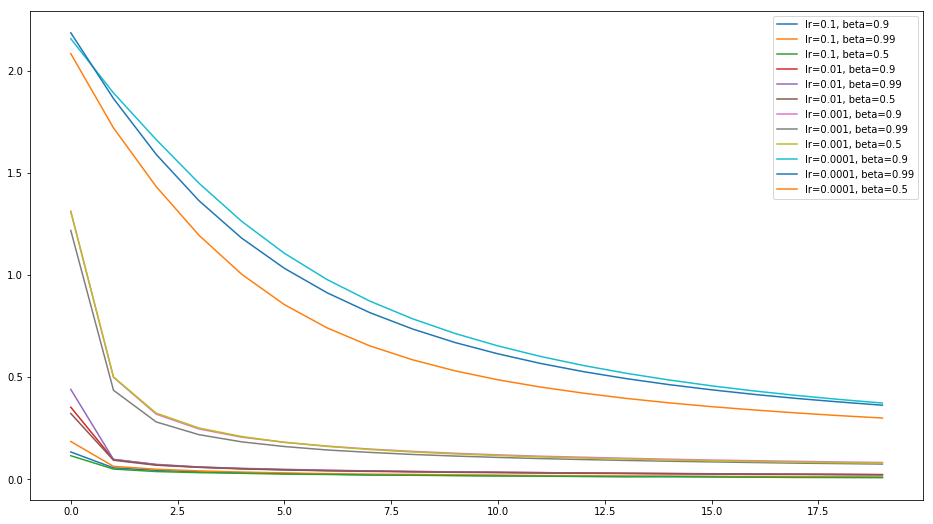

In [43]:
plt.figure(figsize=(16,9))
for (curve_sgd, lr, beta) in loss_curve_sgd_momentum:
    plt.plot(curve_sgd, label="lr={}, beta={}".format(lr, beta))

plt.legend()
plt.show()

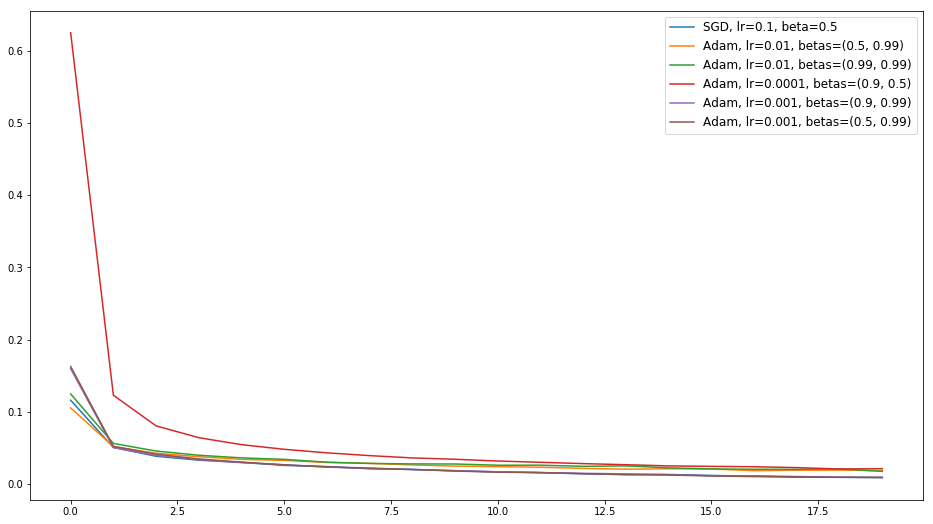

In [47]:
# best of the best
plt.figure(figsize=(16,9))
for (curve_sgd, lr, beta) in loss_curve_sgd_momentum:
    if lr == 0.1 and beta == 0.5:
        plt.plot(curve_sgd, label="SGD, lr={}, beta={}".format(lr, beta))
for (curve_adam, lr, betas) in loss_curve_adam:
    if lr == 0.01 and (betas == (0.99, 0.99) or betas == (0.5, 0.99)):
        plt.plot(curve_adam, label="Adam, lr={}, betas={}".format(lr, betas))
for (curve_adam, lr, betas) in loss_curve_adam:
    if lr == 0.0001 and betas==(0.9, 0.5):
        plt.plot(curve_adam, label="Adam, lr={}, betas={}".format(lr, betas))
for (curve_adam, lr, betas) in loss_curve_adam:
    if lr == 0.001 and (betas == (0.5, 0.99) or betas == (0.9, 0.99)):
        plt.plot(curve_adam, label="Adam, lr={}, betas={}".format(lr, betas))
        
plt.legend(fontsize='large')
plt.show()

**Вывод** Лучше всего себя показали Adam c lr == 0.001 и betas == (0.9, 0.99) и betas == (0.5, 0.99), а также SGD + Momentum с параметрами lr == 0.1, beta == 0.5